In [2]:
import matplotlib.pyplot as plt
import numba
import numpy as np
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
from gudhi.clustering.tomato import Tomato
import umap
import torch
import plotly.graph_objects as go
from persim import plot_diagrams
from collections import Counter
from circular_cords import get_coords
from fix_umap_bug import fix_umap_bug

fix_umap_bug()

Import the data. "activity" is then a 40000xneurons matrix with all activations.

In [4]:
activity = np.load("activations/ILSVRC2015/inception3a.npy")
print(activity.shape)
neurons = activity.shape[1]

(50761, 256)


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse


A_sparse = sparse.csr_matrix(activity)

similarities = cosine_similarity(A_sparse)

In [15]:
new_mat = 2 - 2 * similarities
print(new_mat)

[[-2.3841858e-07  1.3408430e+00  1.4756036e+00 ...  1.1241106e+00
   1.2230604e+00  1.4458468e+00]
 [ 1.3408430e+00  0.0000000e+00  1.3646418e+00 ...  1.4890443e+00
   1.4084387e+00  1.4135478e+00]
 [ 1.4756036e+00  1.3646418e+00 -2.3841858e-07 ...  1.5856588e+00
   1.3771613e+00  1.4733902e+00]
 ...
 [ 1.1241106e+00  1.4890443e+00  1.5856588e+00 ...  1.1920929e-07
   1.3197920e+00  1.4688488e+00]
 [ 1.2230604e+00  1.4084387e+00  1.3771613e+00 ...  1.3197920e+00
   1.1920929e-07  1.2654068e+00]
 [ 1.4458468e+00  1.4135478e+00  1.4733902e+00 ...  1.4688488e+00
   1.2654068e+00  1.1920929e-07]]


In [16]:
mat = new_mat.round(decimals=4)
print(mat)

[[-0.      1.3408  1.4756 ...  1.1241  1.2231  1.4458]
 [ 1.3408  0.      1.3646 ...  1.489   1.4084  1.4135]
 [ 1.4756  1.3646 -0.     ...  1.5857  1.3772  1.4734]
 ...
 [ 1.1241  1.489   1.5857 ...  0.      1.3198  1.4688]
 [ 1.2231  1.4084  1.3772 ...  1.3198  0.      1.2654]
 [ 1.4458  1.4135  1.4734 ...  1.4688  1.2654  0.    ]]


Use UMap to project to 2D

In [17]:
layout_2d = umap.UMAP(
    n_components=2,
    verbose=True,
    n_neighbors=20,
    min_dist=0.01,
    metric="precomputed",  # cosine
).fit_transform(mat)

/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


UMAP(metric='precomputed', min_dist=0.01, n_neighbors=20, verbose=True)
Tue May 31 17:08:10 2022 Construct fuzzy simplicial set
Tue May 31 17:09:02 2022 Finding Nearest Neighbors
Tue May 31 17:09:46 2022 Finished Nearest Neighbor Search
Tue May 31 17:10:13 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue May 31 17:10:48 2022 Finished embedding


In [22]:
layout = umap.UMAP(
    n_components=neurons, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(activity)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=1024, n_neighbors=20, verbose=True)
Tue May 31 17:14:43 2022 Construct fuzzy simplicial set
Tue May 31 17:14:43 2022 Finding Nearest Neighbors
Tue May 31 17:14:43 2022 Building RP forest with 16 trees
Tue May 31 17:14:44 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Tue May 31 17:14:48 2022 Finished Nearest Neighbor Search
Tue May 31 17:14:48 2022 Construct embedding


KeyboardInterrupt: 

Cluster the UMap output with kMeans to get 10 cluster. Then visualize.

In [3]:
t = Tomato(density_type="logDTM", k=200)  # logDTM, DTM, ‘KDE’ or ‘logKDE’
clusters = t.fit_predict(activity)
t.plot_diagram()

KeyboardInterrupt: 

In [7]:
print(t.n_clusters_)
print(Counter(t.labels_).most_common(10))
clusters = t.labels_

72
[(51, 4106), (21, 3670), (29, 2647), (31, 2206), (42, 1995), (6, 1848), (1, 1847), (57, 1574), (25, 1288), (65, 1220)]


/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/matplotlib/collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


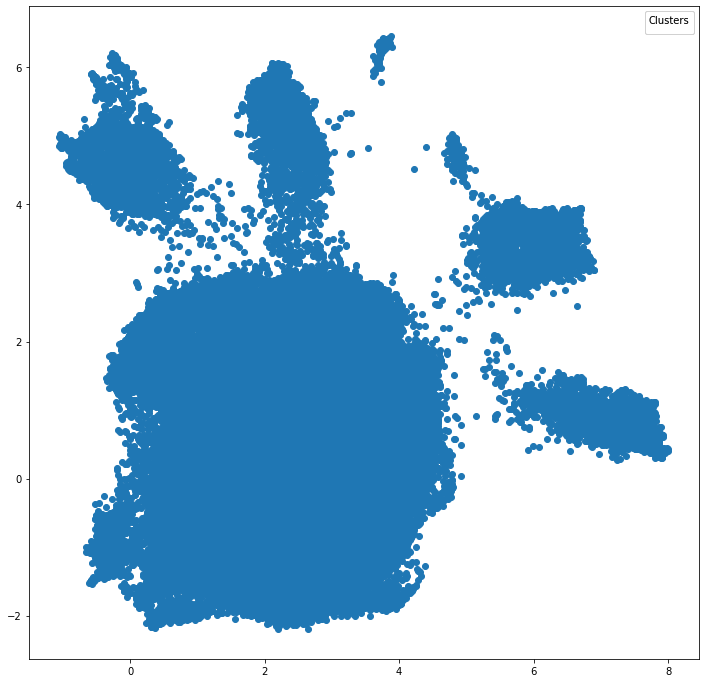

In [6]:
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(x=layout_2d[:, 0], y=layout_2d[:, 1])  # , c=clusters)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/matplotlib/collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


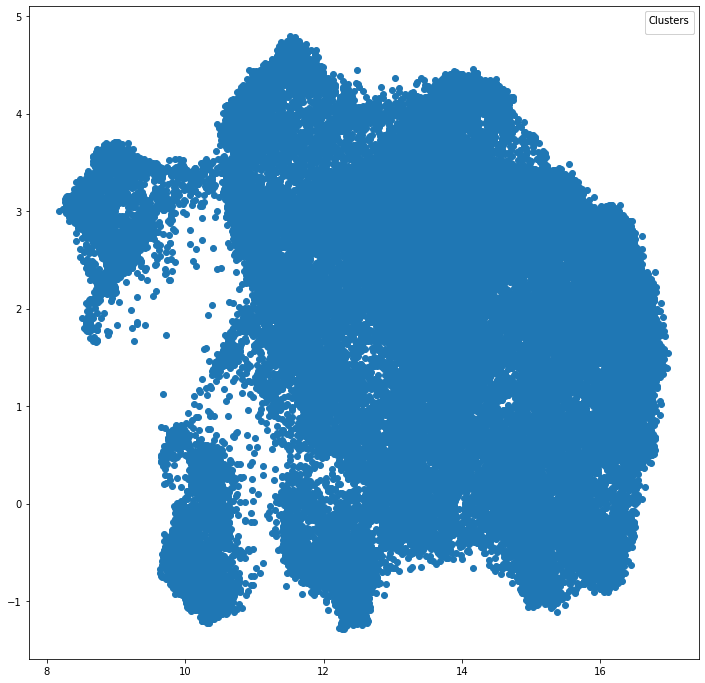

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(x=layout_2d[:, 0], y=layout_2d[:, 1])  # , c=clusters)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/matplotlib/collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


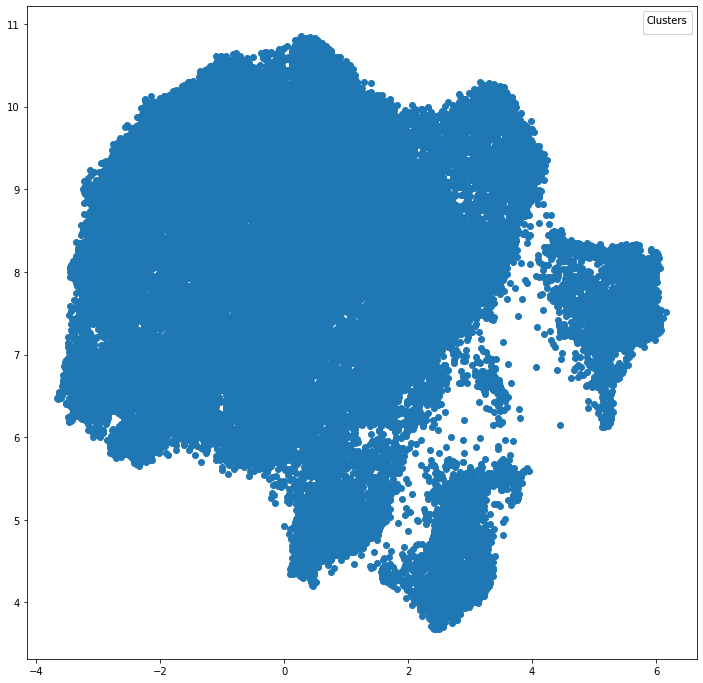

In [18]:
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(x=layout_2d[:, 0], y=layout_2d[:, 1])  # , c=clusters)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()

In cluster 7 there is a circle in the activations. To see it we apply UMAp as a prepocessing step. Then it's visible with persistent homology. 

In [9]:
cluster = []
for n in range(len(clusters)):
    if clusters[n] in [29]:
        cluster.append(activity[n])
cluster = np.array(cluster)
print(cluster.shape)

(2647, 512)


In [10]:
layout2 = umap.UMAP(
    n_components=neurons, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)
M = squareform(pdist(layout2, "euclidean"))

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=512, n_neighbors=20, verbose=True)
Tue Mar  8 15:22:54 2022 Construct fuzzy simplicial set
Tue Mar  8 15:22:58 2022 Finding Nearest Neighbors
Tue Mar  8 15:22:59 2022 Finished Nearest Neighbor Search
Tue Mar  8 15:23:00 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Mar  8 15:23:28 2022 Finished embedding


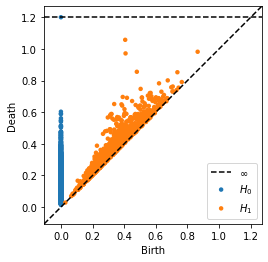

In [11]:
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)

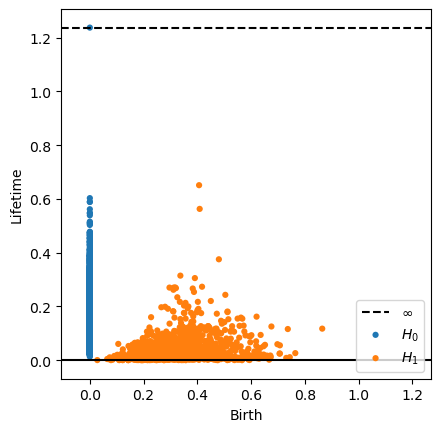

In [12]:
plot_diagrams(persistence["dgms"], lifetime=True, show=True)

Use the code to compute a circular parameter for the identified circle using circular parametrization (de Silva):

In [26]:
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]]) * (9 / 10)


f, theta_matrix, verts, num_verts = get_coords(
    cocycle=cocycles[iMax[-1]],
    threshold=threshold,
    num_sampled=len(layout2),
    dists=M,
    coeff=coeff,
    bool_smooth_circle="graph",  # "graph", "old", "perea"
)

number of vertices = 2647
number of edges = 257481


Visualize it after projecting to 3d: 

In [27]:
layout_3d = umap.UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d[:, 0],
            y=layout_3d[:, 1],
            z=layout_3d[:, 2],
            mode="markers",
            marker=dict(
                size=12, color=f, colorscale="hsv", opacity=0.8, showscale=True
            ),
        )
    ]
)
# Cyclic colors: 'twilight', 'twilight_shifted', 'hsv', Default: Viridis
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("circular_feature_3D.html")
fig.show()

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Tue Mar  8 19:45:07 2022 Construct fuzzy simplicial set
Tue Mar  8 19:45:11 2022 Finding Nearest Neighbors
Tue Mar  8 19:45:11 2022 Finished Nearest Neighbor Search
Tue Mar  8 19:45:11 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Mar  8 19:45:13 2022 Finished embedding


Not all neurons contribute equally to this circle. We identify the ones that tune to it: 

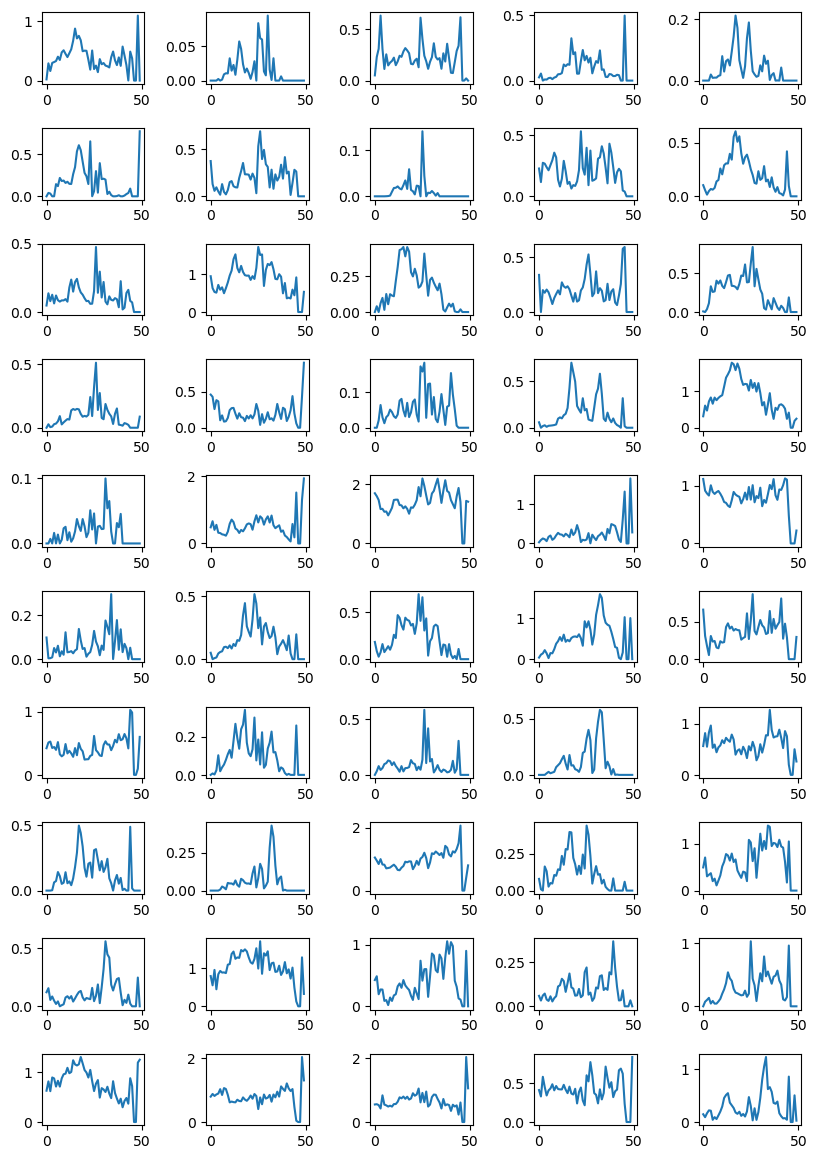

In [35]:
circ_rates = np.zeros([neurons, 50])
counts, bins = np.histogram(f, bins=50, density=True)
for b in range(len(bins) - 1):
    for n in range(neurons):
        rates = []
        for x in range(len(cluster)):
            if bins[b] < f[x] <= bins[b + 1]:
                rates.append(cluster[x, n])
        if rates:
            circ_rates[n, b] = np.mean(rates)
        else:
            circ_rates[n, b] = 0

fig, axs = plt.subplots(10, 5, figsize=(8.27, 11.69))
for n in range(5):
    for m in range(10):
        axs[m, n].plot(range(50), circ_rates[m * 5 + n])
fig.tight_layout()

To quantify this we compute the information rate of the neurons:

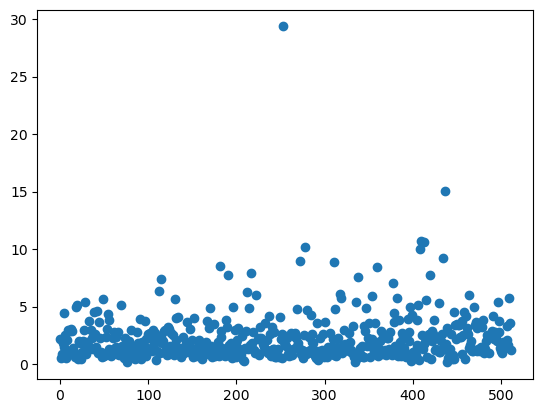

In [37]:
def inform_rate(mean_n, data, coun):
    return np.sum(data * np.log2((data / mean_n) + 0.0000001) * coun)


mean = np.mean(cluster, axis=0)

inform_rates = [inform_rate(mean[n], circ_rates[n, :], counts) for n in range(neurons)]

plt.scatter(range(neurons), inform_rates)
plt.show()

Then we pick the ones with an information rate higher then 0.2:

In [49]:
inform = 5
high_inform = np.where(np.array(inform_rates) > inform)[0]
print(high_inform)
len(high_inform)

[ 19  28  49  69 112 115 130 181 190 212 217 222 253 272 278 310 317 318
 335 338 353 359 377 382 406 408 409 413 415 419 430 434 436 464 496 509]


36

Lets compute everything again but just with these neurons:

In [50]:
cluster_new = cluster[:, np.where(np.array(inform_rates) > inform)[0]]
data_new = activity[:, np.where(np.array(inform_rates) > inform)[0]]

layout_3d_cluster = umap.UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster_new)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Tue Mar  8 23:46:54 2022 Construct fuzzy simplicial set
Tue Mar  8 23:46:56 2022 Finding Nearest Neighbors
Tue Mar  8 23:46:56 2022 Finished Nearest Neighbor Search
Tue Mar  8 23:46:56 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Mar  8 23:46:57 2022 Finished embedding


In [51]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_cluster[:, 0],
            y=layout_3d_cluster[:, 1],
            z=layout_3d_cluster[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f,
                colorscale="hsv",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("circular_feature_3D_after_clustering_2.html")
fig.show()

In [52]:
cluster_new_crop = cluster_new[
    np.where(
        (np.array(layout_3d_cluster)[:, 0] > 9)
        & (np.array(layout_3d_cluster)[:, 1] < 7)
        & (np.array(layout_3d_cluster)[:, 2] > 4.8)
    )[0],
    :,
]
# cluster_new_crop = cluster_new
layout_3d_new = umap.UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster_new_crop)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Tue Mar  8 23:50:15 2022 Construct fuzzy simplicial set
Tue Mar  8 23:50:15 2022 Finding Nearest Neighbors
Tue Mar  8 23:50:15 2022 Finished Nearest Neighbor Search
Tue Mar  8 23:50:15 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Mar  8 23:50:17 2022 Finished embedding


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=36, n_neighbors=20, verbose=True)
Tue Mar  8 23:51:17 2022 Construct fuzzy simplicial set
Tue Mar  8 23:51:18 2022 Finding Nearest Neighbors
Tue Mar  8 23:51:18 2022 Finished Nearest Neighbor Search
Tue Mar  8 23:51:18 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Mar  8 23:51:20 2022 Finished embedding


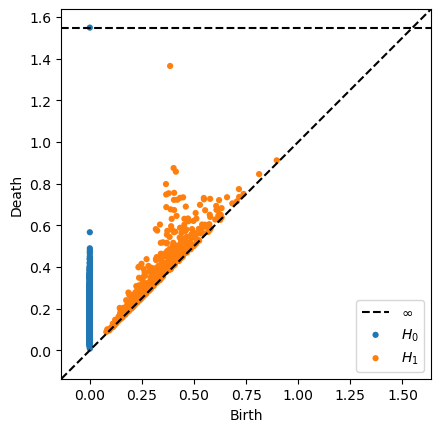

In [54]:
layout3 = umap.UMAP(
    n_components=len(high_inform),
    verbose=True,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
).fit_transform(cluster_new_crop)
M = squareform(pdist(layout3, "euclidean"))
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes

plot_diagrams(diagrams, show=True)
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]]) * (9 / 10)

cocycle = cocycles[iMax[-1]]

In [56]:
f_new, theta_matrix, verts_new, num_verts = get_coords(
    cocycle,
    threshold,
    len(layout3),
    M,
    47,
    "perea",  # "graph", "old", "perea"
)

number of vertices = 1784
number of edges = 187763


In [57]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_new[:, 0],
            y=layout_3d_new[:, 1],
            z=layout_3d_new[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f_new,
                colorscale="hsv",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("circular_feature_3D_final.html")
fig.show()

In [58]:
np.save(f"data/circle_4b", cluster)

We visulize the circle using using the lucent library. For that end we calculate average activation vectors for 50 overlapping patches along the circular parameter, Then we visulize those 50 average activation vectors. 

In [42]:
buckets = 25
linsp = np.linspace(f_new.min(), f_new.max(), buckets + 1)

clusters_overlap = []
for a in range(1, buckets):
    c = []
    for p in range(len(f_new)):
        if linsp[a - 1] < f_new[p] < linsp[a + 1]:
            c.append(cluster_new_crop[p])
    clusters_overlap.append(c)

c = []
for p in range(len(f_new)):
    if linsp[buckets - 1] < f_new[p] or f_new[p] < linsp[1]:
        c.append(cluster_new_crop[p])
clusters_overlap.append(c)
av_clusters_overlap = [np.mean(overlap, axis=0) for overlap in clusters_overlap]

print(list(map(lambda a: a.shape, av_clusters_overlap)))
print(list(map(len, clusters_overlap)))

[(38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,)]
[15, 19, 91, 98, 66, 89, 101, 152, 151, 80, 45, 29, 35, 85, 113, 82, 34, 6, 86, 185, 139, 80, 70, 87, 74]


Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.87it/s]



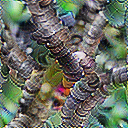

100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.03it/s]



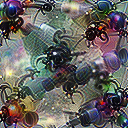

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.99it/s]



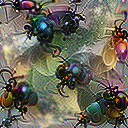

100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.09it/s]



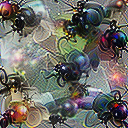

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.93it/s]



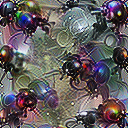

100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.08it/s]



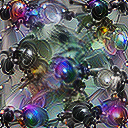

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.94it/s]



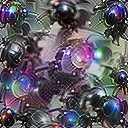

100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.00it/s]



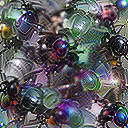

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.70it/s]



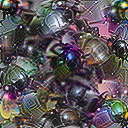

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.85it/s]



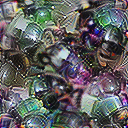

100%|█████████████████████████████████████████| 512/512 [01:10<00:00,  7.24it/s]



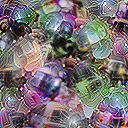

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.67it/s]



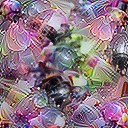

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.91it/s]



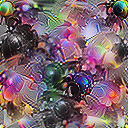

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.79it/s]



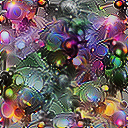

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.93it/s]



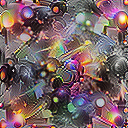

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.83it/s]



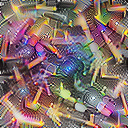

100%|█████████████████████████████████████████| 512/512 [01:33<00:00,  5.47it/s]



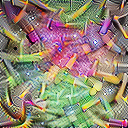

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.65it/s]



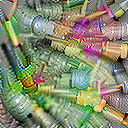

100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.02it/s]



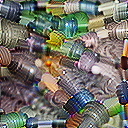

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.93it/s]



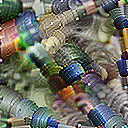

100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.13it/s]



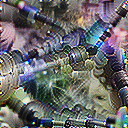

100%|█████████████████████████████████████████| 512/512 [01:00<00:00,  8.50it/s]



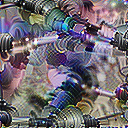

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.94it/s]



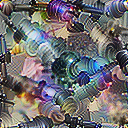

100%|█████████████████████████████████████████| 512/512 [01:15<00:00,  6.76it/s]



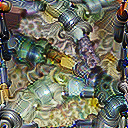

100%|█████████████████████████████████████████| 512/512 [01:07<00:00,  7.54it/s]



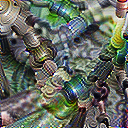

In [43]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics = []
channel = lambda n: objectives.channel("inception4e", n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics.append(d)

Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.88it/s]



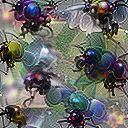

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.91it/s]



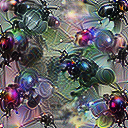

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.93it/s]



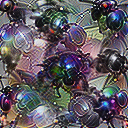

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.78it/s]



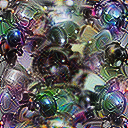

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.88it/s]



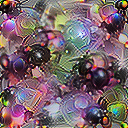

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.82it/s]



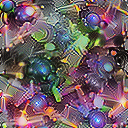

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.76it/s]



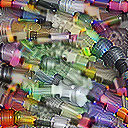

100%|█████████████████████████████████████████| 512/512 [01:07<00:00,  7.54it/s]



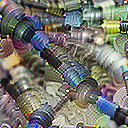

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.83it/s]



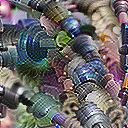

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.73it/s]



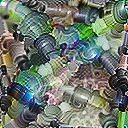

In [39]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics = []
channel = lambda n: objectives.channel("inception4e", n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics.append(d)

In [45]:
for i, im in enumerate(pics):
    np.save(f"data/circle_pics/circle_3/im_{i}.npy", im[0][0])

In [46]:
from PIL import Image

a = np.load("data/circle_pics/circle_3/im_1.npy")

a = (a * 255).astype(np.uint8)

ima = Image.fromarray(obj=a, mode="RGB")
ima.show()